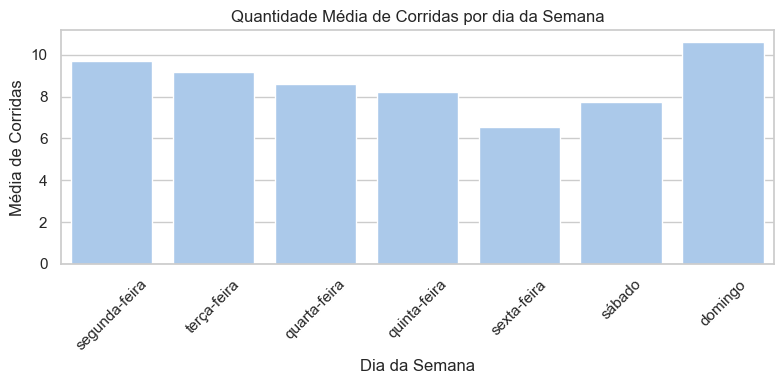

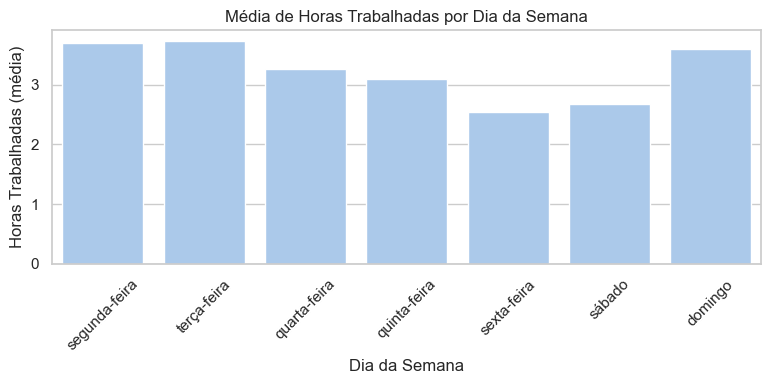

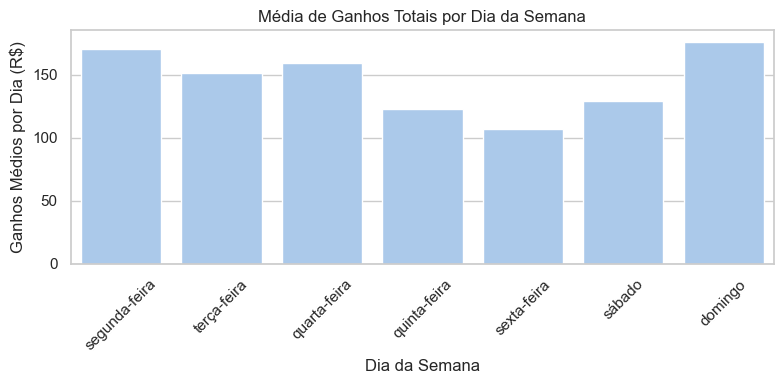

         Order ID Order status Order call PAX/Date Order call PAX/Hour  \
0  22073875050856     finished          2025-02-24     0 days 02:15:11   
1  22073895862148   unfinished          2025-02-24     0 days 07:54:07   
2  22073873137160     finished          2025-02-24     0 days 01:33:52   
3  22073894868580     finished          2025-02-24     0 days 07:39:38   
4  22073894850000   unfinished          2025-02-24     0 days 07:39:48   

  Order call PAX/Day Driver answer/Date Driver answer/Hour  \
0      segunda-feira         2025-02-24           02:15:23   
1      segunda-feira         2025-02-24           07:54:49   
2      segunda-feira         2025-02-24           01:34:55   
3      segunda-feira         2025-02-24           07:40:28   
4      segunda-feira         2025-02-24           07:40:03   

       Departure Time          Cancel Time Order complete time  \
0 2025-02-24 02:15:10                  NaN 2025-02-24 02:40:16   
1 2025-02-24 07:53:49  2025-02-24 08:05:18 2025-02

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta

sns.set(style="whitegrid", palette = "pastel")

df = pd.read_excel(r"C:\Users\Tiago\Desktop\Vitor Docs\99 Analitycs\motorista-data-insights\data\Dados99.xlsx", sheet_name = "order_info")

#converte colunas data e hora
df["Order call PAX/Date"] = pd.to_datetime(df["Order call PAX/Date"])
df["Order call PAX/Hour"] = df["Order call PAX/Hour"].apply(lambda t: pd.to_timedelta(datetime.timedelta(hours=t.hour, minutes=t.minute, seconds=t.second)))
df["Order complete time"] = pd.to_datetime(df["Order complete time"], errors='coerce')
df["Departure Time"] = pd.to_datetime(df["Departure Time"], errors='coerce')

#coverte duracao em minutos
df["Duration_min"] = df["Order duration/Seconds"] / 60

#converte distancia
df["Charged  Distance"] = pd.to_numeric(df["Charged  Distance"], errors='coerce')

#converte valor recebido pela corrida
df["Total fee"] = pd.to_numeric(df["Total fee"], errors='coerce')

#filtra corridas finalizadas com valor
df_finalizadas = df[(df["Order status"] == "finished") & (df["Total fee"].notnull())]

ordem_dias = ["segunda-feira", "terça-feira", "quarta-feira", "quinta-feira", "sexta-feira", "sábado", "domingo"]

##grafico de corridas por dia da semana
dias_unicos_semana = df_finalizadas.groupby("Order call PAX/Day")["Order call PAX/Date"].nunique()
corridas_totais = df_finalizadas["Order call PAX/Day"].value_counts()
media_corridas_por_dia = (corridas_totais / dias_unicos_semana).reindex(ordem_dias)

plt.figure(figsize=(8,4))
sns.barplot(x=media_corridas_por_dia.index, y=media_corridas_por_dia.values)
plt.title("Quantidade Média de Corridas por dia da Semana")
plt.xlabel("Dia da Semana")
plt.ylabel("Média de Corridas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##grafico de media de horas trabalhadas por dia da semana
df_finalizadas = df_finalizadas.sort_values(by=["Order call PAX/Date", "Departure Time"])

df_finalizadas["data"] = df_finalizadas["Order call PAX/Date"]
df_finalizadas["dia_semana"] = df_finalizadas["Order call PAX/Day"]

#calcula o tempo de inatividade entre corridas(dentro do mesmo dia)
df_finalizadas["tempo_espera"] = df_finalizadas.groupby("data")["Departure Time"].diff()

#se gap for maior que 1h, considerar inicio de novo período de trabalho
limite_gap = timedelta(hours=1)
df_finalizadas["novo_periodo"] = (df_finalizadas["tempo_espera"] > limite_gap).fillna(True).astype(int)

df_finalizadas["id_sessao"] = df_finalizadas.groupby("data")["novo_periodo"].cumsum()

sessoes = df_finalizadas.groupby(["data", "dia_semana", "id_sessao"]).agg({
    "Departure Time": "min",
    "Order complete time": "max"
}).reset_index()
sessoes["duracao_horas"] = (sessoes["Order complete time"] - sessoes["Departure Time"]).dt.total_seconds() / 3600

horas_por_dia = sessoes.groupby(["data", "dia_semana"])["duracao_horas"].sum().reset_index()

media_refinada = horas_por_dia.groupby("dia_semana")["duracao_horas"].mean().reindex(ordem_dias)

#cria o grafico
plt.figure(figsize=(8,4))
sns.barplot(x=media_refinada.index, y=media_refinada.values)
plt.title("Média de Horas Trabalhadas por Dia da Semana")
plt.xlabel("Dia da Semana")
plt.ylabel("Horas Trabalhadas (média)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##grafico da media de ganhos do motorista por dia da semana
#agrupa por data e soma os ganhos por dia
ganhos_por_dia = df_finalizadas.groupby(["Order call PAX/Date", "Order call PAX/Day"])["Total fee"].sum().reset_index()
ganhos_por_dia.columns = ["data", "dia_semana", "ganho_total_dia"]

media_ganhos = ganhos_por_dia.groupby("dia_semana")["ganho_total_dia"].mean().reindex(ordem_dias)

#cria o grafico
plt.figure(figsize=(8,4))
sns.barplot(x=media_ganhos.index, y=media_ganhos.values)
plt.title("Média de Ganhos Totais por Dia da Semana")
plt.xlabel("Dia da Semana")
plt.ylabel("Ganhos Médios por Dia (R$)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


print(df.head())
print(df.info())

